# Nettoyage des donnees avant de les enregistrer en BDD

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
import os

from modules.data_cleaning import apply_zscore, \
                                  category_list_encoding, \
                                  get_volume

raw = '../../datas/RAW/E2/'

# Chargement des csv

In [2]:
dict_csv = {
    'customer':         'olist_customers_dataset.csv',
    'order':            'olist_orders_dataset.csv', 
    'order_items':      'olist_order_items_dataset.csv', 
    'product':          'olist_products_dataset.csv', 
    'seller':           'olist_sellers_dataset.csv'
}
for csv in dict_csv:
    dict_csv[csv] = (pd.read_csv(raw + dict_csv[csv]))
dict_csv.keys()

dict_keys(['customer', 'order', 'order_items', 'product', 'seller'])

# Nettoyage des donnees

## Drop na values

sur la table order, j'en profite pour supprimer les 6 commandes annulees (canceled)

In [3]:
for df in dict_csv:
    if dict_csv[df].isna().sum().sum() != 0:
        print('\t' + df.upper())
        print(dict_csv[df].isna().sum())

	ORDER
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
	PRODUCT
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


In [4]:
order_without_na = dict_csv['order'].dropna()
order_without_na = order_without_na[order_without_na.order_status == 'delivered']
print('Nb de lignes avant et apres traitement')
print(dict_csv['order'].shape)
print(order_without_na.shape)

dict_csv['order'] = order_without_na

Nb de lignes avant et apres traitement
(99441, 8)
(96455, 8)


In [5]:
product_without_na = dict_csv['product'].dropna()
print('Nb de lignes avant et apres traitement')
print(dict_csv['product'].shape)
print(product_without_na.shape)

dict_csv['product'] = product_without_na

Nb de lignes avant et apres traitement
(32951, 9)
(32340, 9)


## Drop outliers

J'applique un zscore uniquement sur la table order_items

In [6]:
dict_csv['order_items'].price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

<AxesSubplot:>

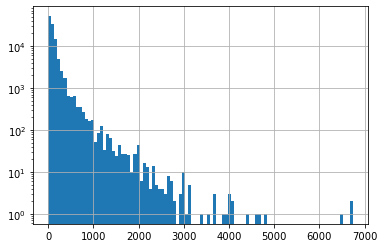

In [7]:
dict_csv['order_items'].price.hist(bins=100, log=True)

(109092, 7)

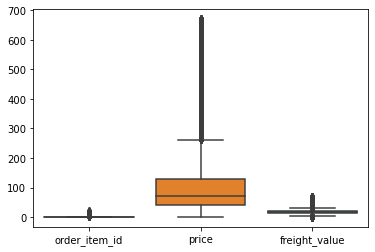

In [8]:
order_items_zscore = apply_zscore(dict_csv['order_items'], ['price', 'freight_value'])
ax = sns.boxplot(data=order_items_zscore)
order_items_zscore.shape

# Jointure des differentes tables

<img src="../documentation/data_schema_essential.png" alt="Schéma des tables du dataset" style="height: 300px;"/>

## Jointure customer et order

In [9]:
df_order_customer = dict_csv['order'].merge(dict_csv['customer'], how='inner', on='customer_id')
df_order_customer = df_order_customer.drop(['customer_unique_id', 'customer_id', 'customer_zip_code_prefix'], axis=1)
df_order_customer.head(5)

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,santo andre,SP


## Jointure order items et order

In [10]:
print(dict_csv['order_items'].shape)
df_join = dict_csv['order_items'].merge(df_order_customer, how='inner', on='order_id')
print(df_join.shape)
df_join.head(5)

(112650, 7)
(110173, 15)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,varzea paulista,SP


## Jointure order items et seller

In [11]:
print(df_join.shape)
df_join = df_join.merge(dict_csv['seller'], how='inner', on='seller_id')
df_join = df_join.drop(['seller_id', 'seller_zip_code_prefix'], axis=1)
print(df_join.shape)
df_join.head(5)

(110173, 15)
(110173, 16)


,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,2017-09-19 09:45:35,58.9,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,campos dos goytacazes,RJ,volta redonda,SP
1,0188777fe321843a18be24a6e9aa1e53,1,436c8d57ff8d4aa254318e9bd9b48c83,2017-07-31 14:35:11,55.9,9.94,delivered,2017-07-23 16:13:37,2017-07-25 14:35:11,2017-07-27 18:45:50,2017-07-28 16:18:00,2017-08-08 00:00:00,duque de caxias,RJ,volta redonda,SP
2,0191bbb5166d4b9a68df11797d5acfa9,1,ec02a5d380128f7a188e9ce8f3ddd832,2017-08-16 12:30:15,132.9,20.17,delivered,2017-08-10 12:17:35,2017-08-10 12:30:15,2017-08-15 19:26:45,2017-08-24 18:15:16,2017-09-08 00:00:00,sao leopoldo,RS,volta redonda,SP
3,03054d8a8eefc2981cfad06f58e27979,1,3e31fd1419cc4cd6adad1925e72e3a03,2017-10-09 10:35:11,58.9,15.16,delivered,2017-10-02 10:25:22,2017-10-03 10:35:11,2017-10-09 17:57:50,2017-10-19 21:03:49,2017-10-25 00:00:00,sao paulo,SP,volta redonda,SP
4,0c325ea6925de749e1420be0cf43587c,1,3a135477bf41350a0b1d8afdf616d446,2017-07-06 15:43:50,139.9,16.74,delivered,2017-07-01 15:27:23,2017-07-01 15:43:50,2017-07-05 12:00:33,2017-07-10 17:17:21,2017-07-25 00:00:00,porto feliz,SP,volta redonda,SP


## Jointure customer et order

In [ ]:
df_order_customer = dict_csv['order'].merge(dict_csv['customer'], how='inner', on='customer_id')
df_order_customer = df_order_customer.drop(['customer_unique_id', 'customer_id', 'customer_zip_code_prefix'], axis=1)
df_order_customer.head(5)

## Jointure order_items et product

1 a plusieurs

In [12]:
df_join = df_join.merge(dict_csv['product'], how='inner', on='product_id')
df_join = df_join.drop(columns=['product_description_lenght', 'product_name_lenght', 'product_photos_qty', 'product_id'])
df_join = df_join.sort_values(by='product_category_name')
df_join.head(5)

,order_id,order_item_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,seller_city,seller_state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
21633,bd1b3292531bf8f2cf14a4f448b2226e,1,2018-03-26 23:31:39,19.5,8.29,delivered,2018-03-20 23:22:32,2018-03-20 23:35:35,2018-03-21 20:32:23,2018-03-28 13:06:40,2018-04-02 00:00:00,sao paulo,SP,sao paulo,SP,agro_industria_e_comercio,500.0,17.0,11.0,11.0
13983,dac9b7a51d7f27bbcfa19b93433f65d2,1,2018-03-27 02:56:23,412.0,26.20,delivered,2018-03-20 15:08:17,2018-03-21 02:56:23,2018-03-21 21:05:05,2018-04-02 23:32:55,2018-04-24 00:00:00,rio de janeiro,RJ,curitiba,PR,agro_industria_e_comercio,3000.0,30.0,30.0,20.0
13982,d4e1ef173ac9e00a6f0c0bd6954183aa,1,2018-03-01 02:35:49,412.0,17.09,delivered,2018-02-23 15:00:35,2018-02-24 02:35:49,2018-02-26 19:55:39,2018-02-27 20:04:41,2018-03-09 00:00:00,curitiba,PR,curitiba,PR,agro_industria_e_comercio,3000.0,30.0,30.0,20.0
13981,b788267177aac63aeb5b805af8edd8df,1,2018-02-06 14:21:20,412.0,27.72,delivered,2018-01-31 11:48:43,2018-01-31 14:21:20,2018-02-06 22:57:38,2018-02-20 18:44:57,2018-03-01 00:00:00,matao,SP,curitiba,PR,agro_industria_e_comercio,3000.0,30.0,30.0,20.0
13980,b6f97ad9a7a85e2ad594c746a46dab44,1,2018-01-23 17:50:48,412.0,27.72,delivered,2018-01-17 17:34:42,2018-01-17 17:50:48,2018-01-19 18:32:14,2018-01-31 19:22:56,2018-02-14 00:00:00,amparo,SP,curitiba,PR,agro_industria_e_comercio,3000.0,30.0,30.0,20.0


In [13]:
df_weight = df_join.groupby(by='order_id').product_weight_g.agg(sum)
df_weight = df_weight.reset_index()
df_weight = df_weight.rename(columns={'product_weight_g': 'weight'})

df_join = df_join.drop(columns=['product_weight_g'])
df_join = df_join.merge(df_weight, on='order_id', how='inner')

df_join.head(5)

,order_id,order_item_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,seller_city,seller_state,product_category_name,product_length_cm,product_height_cm,product_width_cm,weight
0,bd1b3292531bf8f2cf14a4f448b2226e,1,2018-03-26 23:31:39,19.5,8.29,delivered,2018-03-20 23:22:32,2018-03-20 23:35:35,2018-03-21 20:32:23,2018-03-28 13:06:40,2018-04-02 00:00:00,sao paulo,SP,sao paulo,SP,agro_industria_e_comercio,17.0,11.0,11.0,500.0
1,dac9b7a51d7f27bbcfa19b93433f65d2,1,2018-03-27 02:56:23,412.0,26.20,delivered,2018-03-20 15:08:17,2018-03-21 02:56:23,2018-03-21 21:05:05,2018-04-02 23:32:55,2018-04-24 00:00:00,rio de janeiro,RJ,curitiba,PR,agro_industria_e_comercio,30.0,30.0,20.0,3000.0
2,d4e1ef173ac9e00a6f0c0bd6954183aa,1,2018-03-01 02:35:49,412.0,17.09,delivered,2018-02-23 15:00:35,2018-02-24 02:35:49,2018-02-26 19:55:39,2018-02-27 20:04:41,2018-03-09 00:00:00,curitiba,PR,curitiba,PR,agro_industria_e_comercio,30.0,30.0,20.0,3000.0
3,b788267177aac63aeb5b805af8edd8df,1,2018-02-06 14:21:20,412.0,27.72,delivered,2018-01-31 11:48:43,2018-01-31 14:21:20,2018-02-06 22:57:38,2018-02-20 18:44:57,2018-03-01 00:00:00,matao,SP,curitiba,PR,agro_industria_e_comercio,30.0,30.0,20.0,3000.0
4,b6f97ad9a7a85e2ad594c746a46dab44,1,2018-01-23 17:50:48,412.0,27.72,delivered,2018-01-17 17:34:42,2018-01-17 17:50:48,2018-01-19 18:32:14,2018-01-31 19:22:56,2018-02-14 00:00:00,amparo,SP,curitiba,PR,agro_industria_e_comercio,30.0,30.0,20.0,3000.0


In [15]:
df_volume = df_join.groupby(by='order_id')[['product_length_cm', 'product_height_cm', 'product_width_cm']].agg(list)
df_volume = pd.merge(pd.Series(df_volume.index), get_volume(df_volume), left_index=True, right_index=True)

df_join = df_join.drop(columns=['product_length_cm', 'product_height_cm', 'product_width_cm'])
df_join = df_join.merge(df_volume, on='order_id', how='inner')

df_join.head(5)

,order_id,order_item_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,seller_city,seller_state,product_category_name,weight,volume
0,bd1b3292531bf8f2cf14a4f448b2226e,1,2018-03-26 23:31:39,19.5,8.29,delivered,2018-03-20 23:22:32,2018-03-20 23:35:35,2018-03-21 20:32:23,2018-03-28 13:06:40,2018-04-02 00:00:00,sao paulo,SP,sao paulo,SP,agro_industria_e_comercio,500.0,2057.0
1,dac9b7a51d7f27bbcfa19b93433f65d2,1,2018-03-27 02:56:23,412.0,26.20,delivered,2018-03-20 15:08:17,2018-03-21 02:56:23,2018-03-21 21:05:05,2018-04-02 23:32:55,2018-04-24 00:00:00,rio de janeiro,RJ,curitiba,PR,agro_industria_e_comercio,3000.0,18000.0
2,d4e1ef173ac9e00a6f0c0bd6954183aa,1,2018-03-01 02:35:49,412.0,17.09,delivered,2018-02-23 15:00:35,2018-02-24 02:35:49,2018-02-26 19:55:39,2018-02-27 20:04:41,2018-03-09 00:00:00,curitiba,PR,curitiba,PR,agro_industria_e_comercio,3000.0,18000.0
3,b788267177aac63aeb5b805af8edd8df,1,2018-02-06 14:21:20,412.0,27.72,delivered,2018-01-31 11:48:43,2018-01-31 14:21:20,2018-02-06 22:57:38,2018-02-20 18:44:57,2018-03-01 00:00:00,matao,SP,curitiba,PR,agro_industria_e_comercio,3000.0,18000.0
4,b6f97ad9a7a85e2ad594c746a46dab44,1,2018-01-23 17:50:48,412.0,27.72,delivered,2018-01-17 17:34:42,2018-01-17 17:50:48,2018-01-19 18:32:14,2018-01-31 19:22:56,2018-02-14 00:00:00,amparo,SP,curitiba,PR,agro_industria_e_comercio,3000.0,18000.0


In [17]:
df_group = df_join.groupby(by='order_id').product_category_name.agg(set).reset_index(name='category')
df_group.category = df_group.category.apply(sorted)
df_group = category_list_encoding(df_group, 'category')

# optimisation de la taille
fcols = df_join.select_dtypes('float').columns
df_join[fcols] = df_join[fcols].apply(pd.to_numeric, downcast='float')

df_join = df_join.merge(df_group, on='order_id', how='inner')
df_join = df_join.drop(columns=['product_category_name', 'order_id'])

df_join.head(5)

,order_item_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,cds_dvds_musicais,artes_e_artesanato,moveis_colchao_e_estofado,tablets_impressao_imagem,construcao_ferramentas_ferramentas,fashion_esporte,la_cuisine,pc_gamer,seguros_e_servicos,fashion_roupa_infanto_juvenil
0,1,2018-03-26 23:31:39,19.5,8.29,delivered,2018-03-20 23:22:32,2018-03-20 23:35:35,2018-03-21 20:32:23,2018-03-28 13:06:40,2018-04-02 00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-03-27 02:56:23,412.0,26.20,delivered,2018-03-20 15:08:17,2018-03-21 02:56:23,2018-03-21 21:05:05,2018-04-02 23:32:55,2018-04-24 00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2018-03-01 02:35:49,412.0,17.09,delivered,2018-02-23 15:00:35,2018-02-24 02:35:49,2018-02-26 19:55:39,2018-02-27 20:04:41,2018-03-09 00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2018-02-06 14:21:20,412.0,27.72,delivered,2018-01-31 11:48:43,2018-01-31 14:21:20,2018-02-06 22:57:38,2018-02-20 18:44:57,2018-03-01 00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2018-01-23 17:50:48,412.0,27.72,delivered,2018-01-17 17:34:42,2018-01-17 17:50:48,2018-01-19 18:32:14,2018-01-31 19:22:56,2018-02-14 00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


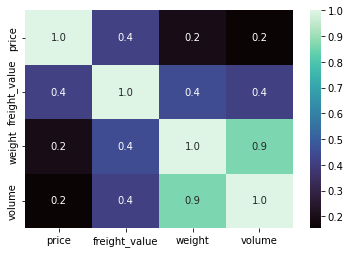

In [25]:
sns.heatmap(
    df_join[df_join.columns[2:16]].corr(),
    cmap='mako',
    annot=True, fmt='.1f'
);

# Calcul des differentes distances

In [ ]:
# temp = df_join[df_join.columns[10:14]]
# temp.head(5)

In [ ]:
# import geocoder
# from geocoder import arcgis

# for row in temp.iloc[4:].itertuples():
#     customer = ' '.join([row.customer_city, row.customer_state, 'brazil'])
#     seller = ' '.join([row.seller_city, row.seller_state, 'brazil'])
#     for adress in (customer, seller):
#         g = arcgis(adress)
#         print(g.latlng)
#     break

# Enregistrement en base de donnees

In [60]:
print(df_join.memory_usage().sum())
fcols = df_join.select_dtypes('float').columns
icols = df_join.select_dtypes('integer').columns

df_join[fcols] = df_join[fcols].apply(pd.to_numeric, downcast='float')
df_join[icols] = df_join[icols].apply(pd.to_numeric, downcast='integer')
print(df_join.memory_usage().sum())

78217920
43997580


In [62]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')

df_join.to_sql(name='clean_data', con=con)

In [71]:
test = pd.read_sql('select * from clean_data', con, index_col='index')
test.head(5)

ProgrammingError: Cannot operate on a closed database.

In [70]:
con.close()